<a href="https://colab.research.google.com/github/weibb123/CustomerSegmentation/blob/main/CustomerSegmentationRetailAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.0 MB/s eta 0:00:00


In [174]:
from faker import Faker
import pandas as pd
import numpy as np

fake = Faker()
data = {
    'CustomerID': [fake.uuid4() for _ in range(1000)],
    'LastPurchaseDate': [fake.date_between(start_date='-1y', end_date='today') for _ in range(1000)],
    'TotalPurchases': np.random.randint(1, 50, 1000),
    'TotalSpent': np.round(np.random.uniform(10, 2000, 1000), 2)
}
df = pd.DataFrame(data)

In [175]:
df.head(5)

,CustomerID,LastPurchaseDate,TotalPurchases,TotalSpent
0,ff5623db-a5b0-494d-97e8-67606197db66,2024-11-18,43,303.40
1,e8a7c5e4-2a44-413e-9842-c920bca607c9,2024-07-07,24,1119.41
2,564ca19d-9bda-421f-b21f-e53075db50c6,2024-12-08,22,1663.91
3,9bc251d3-6a68-430f-b26c-fbb9fd8c1ebb,2024-11-02,27,1335.29
4,1b898853-5498-4df5-b849-11453f13923e,2024-12-01,9,120.24


## Import Libraries

In [176]:
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

df['LastPurchaseDate'] = pd.to_datetime(df['LastPurchaseDate'])
df['Recency'] = (datetime.now() - df['LastPurchaseDate']).dt.days

In [177]:
# Select RFM features
rfm = df[['Recency', 'TotalPurchases', 'TotalSpent']]
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [178]:
# Scale features to [0, 1]
scaler = MinMaxScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm), columns=rfm.columns)

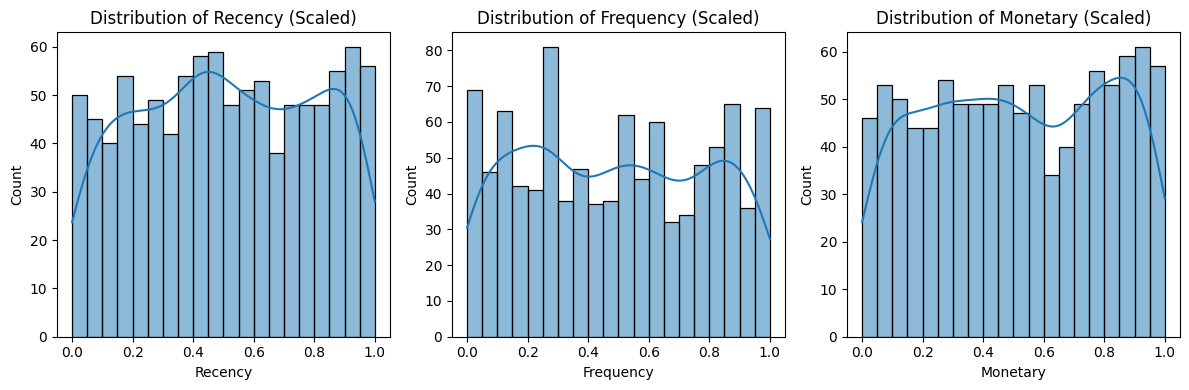

In [189]:
# visualize feature distribution after scaled
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))
for i, col in enumerate(rfm_scaled.columns):
    plt.subplot(1, 3, i+1)
    sns.histplot(rfm_scaled[col], kde=True, bins=20)
    plt.title(f'Distribution of {col} (Scaled)')
plt.tight_layout()
plt.show()

In [184]:
from sklearn.mixture import BayesianGaussianMixture

# Fit Bayesian GMM (set n_components higher than expected)
bgmm = BayesianGaussianMixture(
    n_components=5,               # Max number of components (will prune unused ones)
    weight_concentration_prior=0.1,  # Lower = fewer clusters, Higher = more clusters
    weight_concentration_prior_type='dirichlet_process',
    covariance_type='full',
    init_params='kmeans',
    random_state=42
)
bgmm.fit(rfm_scaled)

# Assign clusters
rfm['Cluster'] = bgmm.predict(rfm_scaled)

# Check inferred clusters
print("Inferred clusters:", np.unique(rfm['Cluster']))
print("Weights of components:", bgmm.weights_)

Inferred clusters: [0 1 2 3 4]
Weights of components: [0.24544399 0.24259698 0.25332378 0.16290824 0.09572701]


In [187]:
bgmm.weights_

array([0.24544399, 0.24259698, 0.25332378, 0.16290824, 0.09572701])

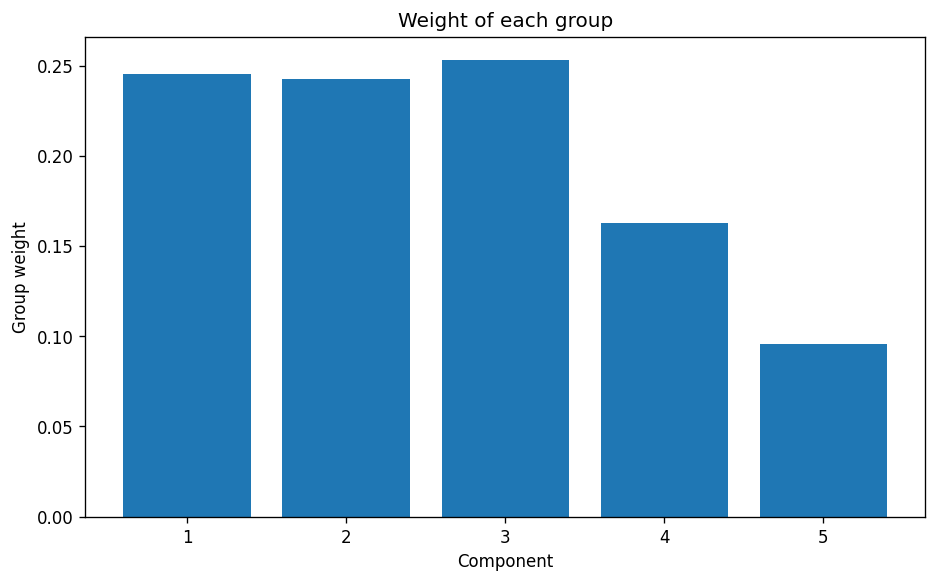

In [188]:
fig = plt.figure(figsize=(7,4), dpi=120)
axes = fig.add_axes([0,0,1,1])
groups = np.arange(len(bgmm.weights_))
axes.bar(groups, bgmm.weights_, align='center', alpha=1.0)
plt.xticks(groups, groups + 1)
plt.ylabel('Group weight')
plt.xlabel('Component')
plt.title('Weight of each group')
plt.show()

In [190]:
bay_gauss = BayesianGaussianMixture(n_components=3, covariance_type='full', weight_concentration_prior_type='dirichlet_process', mean_precision_prior=1, weight_concentration_prior=1, init_params='kmeans', random_state=12)

In [192]:
bay_gauss.fit(rfm_scaled)

# Assign clusters
rfm['Cluster'] = bay_gauss.predict(rfm_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


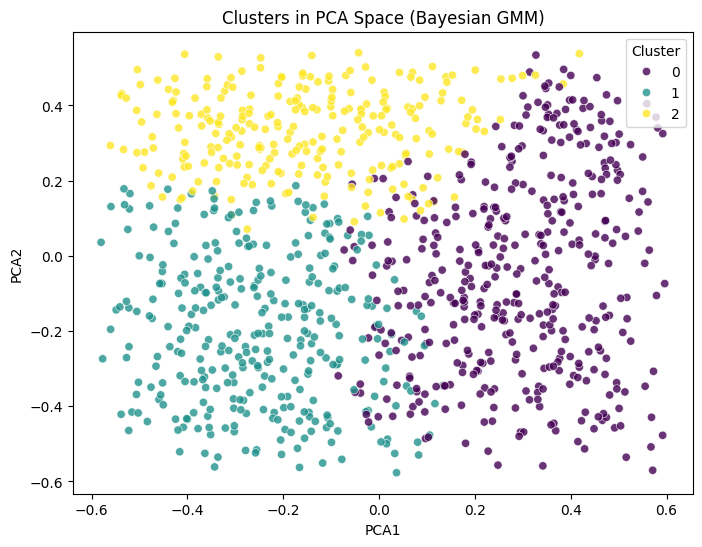

In [194]:
from sklearn.decomposition import PCA

# Reduce to 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# Plot clusters in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', alpha=0.8)
plt.title('Clusters in PCA Space (Bayesian GMM)')
plt.show()

In [195]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
})
print(cluster_summary)

            Recency  Frequency     Monetary      
               mean       mean         mean count
Cluster                                          
0        179.858852  38.564593   942.867225   418
1        182.363914  12.394495   634.721988   327
2        207.431373  16.803922  1687.915294   255


Key Observations
Recency: All clusters have high recency (180–207 days), meaning most customers haven’t purchased in ~6 months.

Frequency:

Cluster 0: Extremely high frequency (38 purchases) → likely bulk buyers or loyalists who stopped purchasing.

Cluster 1: Low frequency (12 purchases) → occasional buyers.

Cluster 2: Moderate frequency (17 purchases) but highest spend → high-value but inactive customers.

Monetary:

Cluster 2 spends 2.6x more than Cluster 1 → critical for revenue recovery.

Business Interpretation
Cluster 0: "Lapsed Loyalists"
Behavior: Purchased frequently but stopped ~6 months ago.

Why They Matter: High historical engagement suggests potential for reactivation.

Hypothesis: Price sensitivity, switched to competitors, or lack of new products.

Cluster 1: "Low-Engagement Shoppers"
Behavior: Infrequent purchases, low spend, inactive for ~6 months.

Why They Matter: Low priority unless reactivation costs are minimal.

Cluster 2: "High-Value Ghosts"
Behavior: Big spenders but inactive for ~7 months.

Why They Matter: Highest potential revenue recovery (avg. $1,687 per customer).

Actionable Recommendations
Cluster 0 (Lapsed Loyalists)
Strategy: Win-back campaigns with personalized incentives.

Example: “We miss you! Enjoy 30% off your next order.”

Goal: Reactivate these previously loyal customers.

Cluster 2 (High-Value Ghosts)
Strategy: High-touch outreach (e.g., personalized emails, exclusive offers).

Example: “Your favorite products are back in stock – early access for you!”

Goal: Leverage their high spending potential.

Cluster 1 (Low-Engagement Shoppers)
Strategy: Low-cost reactivation (e.g., automated email sequences).

Example: “Here’s a 15% discount to welcome you back.”

Goal: Test if they can be converted to repeat buyers.

Why Are All Clusters Inactive?

Data’s LastPurchaseDate spans up to 1 year ago, and clusters reflect this. For real-world projects:

Add recent dates: Ensure data includes recent transactions (e.g., last 30 days).

Balance the data: Include active and inactive customers.

Model Refinement Suggestions

Feature Engineering:

Create a Recency Score: Penalize older purchases (e.g., 1 / Recency).

Add Time-Based Features: Days between purchases, seasonality (e.g., holiday shoppers).

Adjust Bayesian GMM:

Increase n_components to allow more clusters.

Tune weight_concentration_prior (lower values reduce cluster count).

Try Supervised Learning:

Predict churn using labels like “active” (Recency < 90 days) vs. “inactive.”

Next Steps

Validate with Real Data: Test if clusters hold with recent transactions.

A/B Test Campaigns: Target clusters with tailored strategies and measure ROI.

Monitor Trends: Track if clusters shift over time (e.g., loyalty decay).